In [1]:
import itertools
import cv2
import os
import time
import matplotlib.image as mpimg

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tensorflow as tf

from tensorflow import keras

from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D, AveragePooling2D,BatchNormalization,Activation, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from glob import glob

In [2]:
# set data directories
train_dir = os.path.join('lung_image_sets')

# lung adenocarcinoma path
lung_aca = os.path.join('lung_image_sets/lung_aca')

# lung benign path
lung_n = os.path.join('lung_image_sets/lung_n')

# lung squamos cell carcinoma path
lung_scc = os.path.join('lung_image_sets/lung_scc')

In [3]:
%%time
train_aca_names = os.listdir(lung_aca)
print(f'TRAIN SET ADENOCARCINOMA: {train_aca_names[:10]}')
print('\n')

train_n_names = os.listdir(lung_n)
print(f'TRAIN SET BENIGN: {train_n_names[:10]}')
print('\n')

train_scc_names = os.listdir(lung_scc)
print(f'TRAIN SET SQUAMOS CELL CARCINOMA: {train_scc_names[:10]}')

TRAIN SET ADENOCARCINOMA: ['lungaca1.jpeg', 'lungaca10.jpeg', 'lungaca100.jpeg', 'lungaca1000.jpeg', 'lungaca1001.jpeg', 'lungaca1002.jpeg', 'lungaca1003.jpeg', 'lungaca1004.jpeg', 'lungaca1005.jpeg', 'lungaca1006.jpeg']


TRAIN SET BENIGN: ['lungn1.jpeg', 'lungn10.jpeg', 'lungn100.jpeg', 'lungn1000.jpeg', 'lungn1001.jpeg', 'lungn1002.jpeg', 'lungn1003.jpeg', 'lungn1004.jpeg', 'lungn1005.jpeg', 'lungn1006.jpeg']


TRAIN SET SQUAMOS CELL CARCINOMA: ['lungscc1.jpeg', 'lungscc10.jpeg', 'lungscc100.jpeg', 'lungscc1000.jpeg', 'lungscc1001.jpeg', 'lungscc1002.jpeg', 'lungscc1003.jpeg', 'lungscc1004.jpeg', 'lungscc1005.jpeg', 'lungscc1006.jpeg']
CPU times: total: 78.1 ms
Wall time: 84 ms


In [4]:
print(f'total training Adenocarcinoma images: {len(os.listdir(lung_aca))}')
print(f'total training Benign images: {len(os.listdir(lung_n))}')
print(f'total training Squamous Cell Carcinoma images: {len(os.listdir(lung_scc))}')

# calculate number of training images
train_aca = len(os.listdir(lung_aca))
train_n = len(os.listdir(lung_n))
train_scc = len(os.listdir(lung_scc))
total = train_aca + train_n + train_scc

# print total number of images
print('Total Images in dataset: %s' % str((total))) 


total training Adenocarcinoma images: 5000
total training Benign images: 5000
total training Squamous Cell Carcinoma images: 5000
Total Images in dataset: 15000


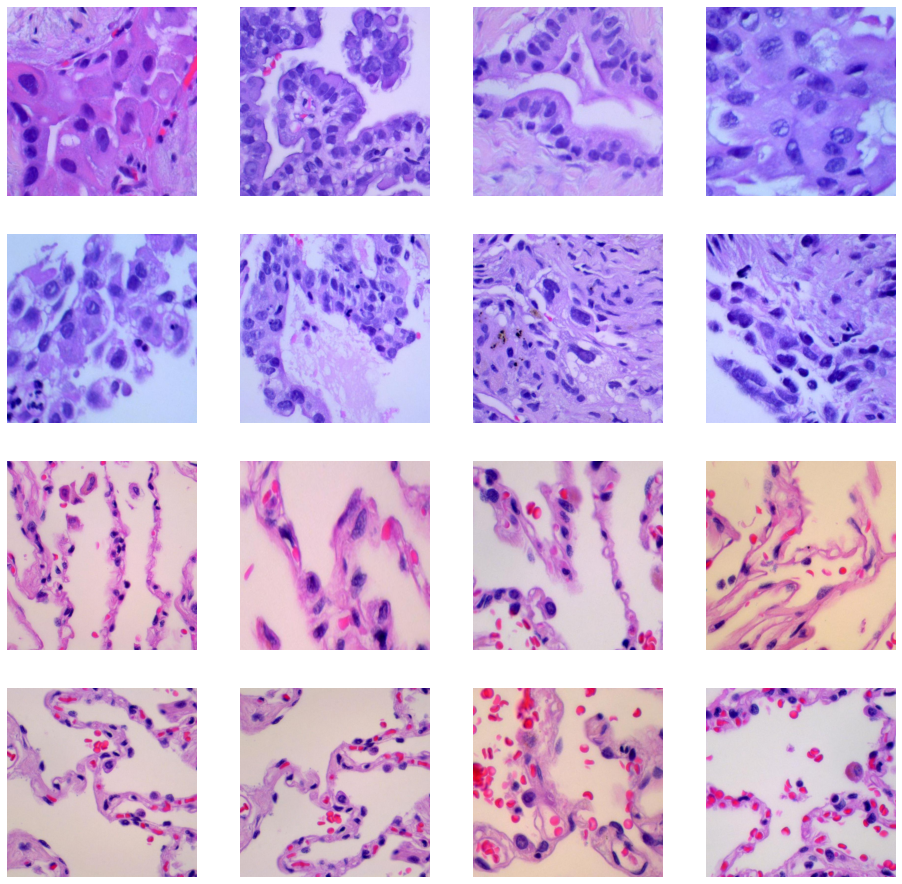

In [5]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_aca_pix = [os.path.join(lung_aca, fname) 
                for fname in train_aca_names[pic_index-8:pic_index]]

next_n_pix = [os.path.join(lung_n, fname) 
                for fname in train_n_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_aca_pix + next_n_pix):
    
  # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

In [6]:
%%time

data_dir = 'lung_image_sets/'

# making a data split of 80-20
data = ImageDataGenerator(validation_split = 0.2)

# setting up the batch size
BATCH_SIZE = 128

# setting up the image size
X = Y = 224

# making training dataset
train_data = data.flow_from_directory(data_dir,
                                    class_mode = "categorical",
                                    target_size = (X, Y),
                                    color_mode="rgb",
                                    batch_size = BATCH_SIZE, 
                                    shuffle = False,
                                    subset='training',
                                    seed = 42)

# making validation dataset
val_data = data.flow_from_directory(data_dir,
                                      class_mode = "categorical",
                                      target_size = (X, Y),
                                      color_mode="rgb",
                                      batch_size = BATCH_SIZE, 
                                      shuffle = False,
                                      subset='validation',
                                      seed = 42)

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.
CPU times: total: 1.72 s
Wall time: 1.59 s


# **InceptionV3(Transfer Learning)**

In [7]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.losses import CategoricalCrossentropy 

base_model=InceptionV3(weights='imagenet',
                      include_top=False,
                      input_shape=(224,224,3))
# This is to ensure the base won't be trained again
base_model.trainable=False

v3model=tf.keras.models.Sequential()
v3model.add(base_model)
v3model.add(GlobalAveragePooling2D())
v3model.add(Dropout(0.2)) # We add a dropout here to prevent overfitting
v3model.add(Dense(3,activation='softmax'))

v3model.summary()
v3model.compile(Adam(0.01), loss = CategoricalCrossentropy(), metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 3)                 6147      
                                                                 
Total params: 21,808,931
Trainable params: 6,147
Non-trainable params: 21,802,784
_________________________________________________________________


In [9]:
# fit the model to the data with the same configuration
v3hisory = v3model.fit(train_data, epochs = 25, steps_per_epoch = len(train_data), validation_data = val_data)

Epoch 1/25
94/94 [==============================] - 162s 2s/step - loss: 19.3568 - accuracy: 0.7203 - val_loss: 18.9384 - val_accuracy: 0.7060
Epoch 2/25
94/94 [==============================] - 162s 2s/step - loss: 47.9318 - accuracy: 0.6783 - val_loss: 22.9965 - val_accuracy: 0.6920
Epoch 3/25
94/94 [==============================] - 162s 2s/step - loss: 26.2805 - accuracy: 0.7272 - val_loss: 10.1930 - val_accuracy: 0.8107
Epoch 4/25
94/94 [==============================] - 161s 2s/step - loss: 25.4399 - accuracy: 0.7272 - val_loss: 9.7998 - val_accuracy: 0.8150
Epoch 5/25
94/94 [==============================] - 159s 2s/step - loss: 37.1450 - accuracy: 0.6991 - val_loss: 11.3720 - val_accuracy: 0.8060
Epoch 6/25
94/94 [==============================] - 160s 2s/step - loss: 39.0034 - accuracy: 0.7097 - val_loss: 166.2735 - val_accuracy: 0.5793
Epoch 7/25
94/94 [==============================] - 159s 2s/step - loss: 32.8764 - accuracy: 0.7351 - val_loss: 10.0218 - val_accuracy: 0.8247

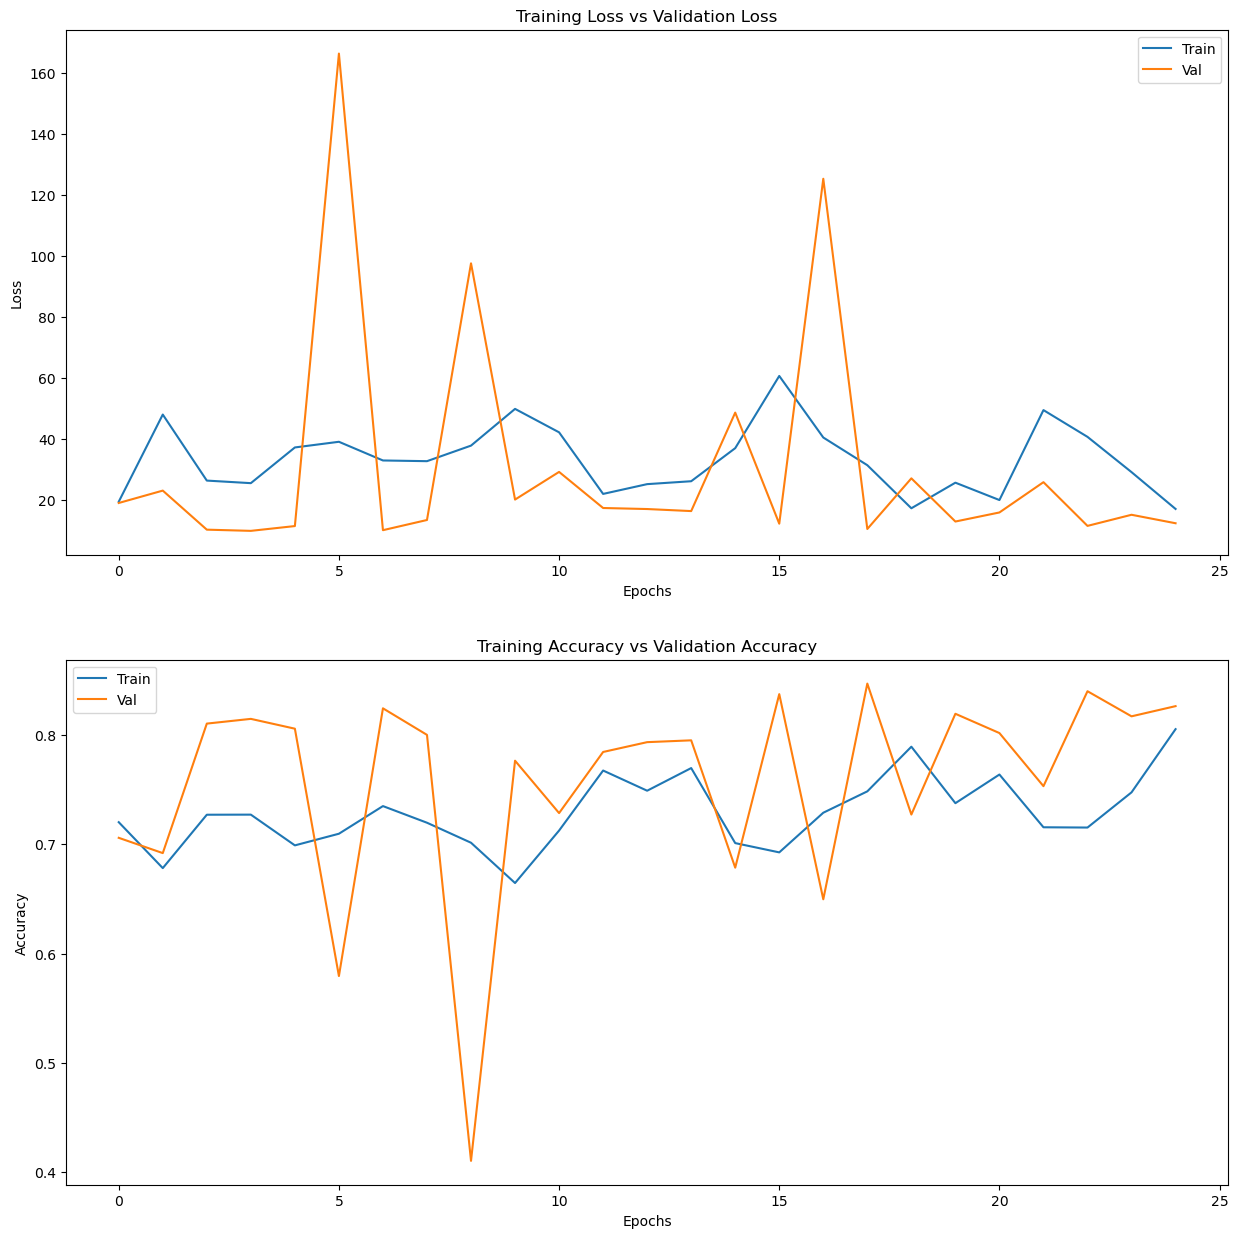

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(v3hisory.history['loss'])
axs[0].plot(v3hisory.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])
axs[1].plot(v3hisory.history['accuracy'])
axs[1].plot(v3hisory.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

In [13]:
from sklearn.metrics import classification_report

Y_pred = v3model.predict(val_data)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(val_data.classes, y_pred))

24/24 [==============================] - 33s 1s/step
              precision    recall  f1-score   support

           0       0.77      0.69      0.73      1000
           1       0.97      0.84      0.90      1000
           2       0.76      0.95      0.85      1000

    accuracy                           0.83      3000
   macro avg       0.84      0.83      0.83      3000
weighted avg       0.84      0.83      0.83      3000

